In [ ]:
#for google drive only
from google.colab import drive
drive.mount('/content/drive')
%cd ../content/drive/My\ Drive/Code/HaikuBot/notebooks/

import nltk
nltk.download('punkt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '../content/drive/My Drive/Code/HaikuBot/notebooks/'
/content/drive/My Drive/Code/HaikuBot/notebooks
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('../')
import utils
from utils.haiku_scrape import scrape_haiku, replace_all, detokenize

import matplotlib.pyplot as plt
import numpy as np
from pickle import dump, load

#TF,nltk, scikit
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from nltk import word_tokenize


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Haiku bot

### How to enforce stanza structure?
- 3 different rnns, each feeding into the next?

### Several approaches to enforce syllable rule:
1. Let the RNN learn on its own and see if it figures it out automatically 
    - Though syllables as a latent variable has very little hints in written text, this might work better with audio data of haikus
2. Restrict number of output units for each stanza as the max number of words/stanza from the data 
    - Then in output, iterate until syllable count satisfied `(while count_syl(stanza) != 5...`
        - This might not be so computationally expensive depending on number of possibile syllables (check this)      
3. Break data down into phoneme/syllable components and feed that through RNN

### Data cleaning
- Some post titles have a preface, amend this by taking all text after a colon?
- `["we", "'ve"]` detokenizes differently than `["do", "n't"]`
- encoder doesn't like single quote quotes `'ex'`
- API has a max number for certain things, e.g. top posts has max 757

### Training
- Removing duplicate training examples *worsens* val accuracy!
- so what hyperparam should I be changing?
  - before: sizes(h_set, train): (2491, 34929)
  - after: (757, 10k)
 
### Embeddings
- transfer learning compare pre trained vs trained 
    - maybe find a poem embedding
- vis with umap

### Architectures 
- consider the bidirectional
- consider train/val split with scikit

# Resources
- https://medium.com/analytics-vidhya/a-comprehensive-guide-to-build-your-own-language-model-in-python-5141b3917d6d
- https://github.com/KhanradCoder/LearnKeras/blob/master/4.RNNs/TextGeneration.ipynb
- [Jason word based 1](https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/)
- [Jason word based 2](https://machinelearningmastery.com/develop-word-based-neural-language-models-python-keras/)
- [return seq](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/)
- [Embeddings](https://blog.dataiku.com/deep-beers-visualizing-embeddings-of-keras-recommendation-engines)

In [ ]:
h_set = scrape_haiku(sort='top',size=1000)
h_set.append('Keep this in your mind. / Only after the clouds cry, / will the rainbow come') #good haiku but had trailing '/'
len(h_set)

757

In [ ]:
len(scrape_haiku(size=100))

146

In [ ]:
repeats = 0
past = []
for h in h_set:
  if h in past:
    repeats+=1
  past.append(h)
  # if 'money' in h:
  #   print(h)
repeats

0

In [ ]:
h_set[:4]

["walls are closing in /  if i don't escape right now /  my life will be squashed $",
 'when we were still young / before the net ensnared us  / days were long and free $',
 'immasculated / dreaming of who i could be / hating who i am $',
 'water in the hand / happiness is ephemeral / a kiss from the wind $']

In [ ]:
token_vocab = []
def prepare_data(haikus,n=3):
    """n: n-gram size"""
    train = [] #n_grams
    for h in haikus:
        tokens = h.split() #word_tokenize(h)
        token_vocab.extend(tokens)
        for i in range(0,len(tokens)):
            n_gram_list = tokens[i:i+n]
            if len(n_gram_list) == n:
                train.append(detokenize(n_gram_list))
            else:
                break
    return train
train = prepare_data(h_set)

In [ ]:
### With tf tokenizer
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(train)
# sequences = tokenizer.texts_to_sequences(train)
# sequences = [i for i in sequences if len(i) == 3] # removing entries with apostrophe for now

# custom tokenizer doesn't skip non letter words
token_vocab = sorted(list(set(token_vocab)))
vocab_size = len(token_vocab) # len(tokenizer.word_index) + 1
print('total # tokens:', vocab_size)
token_indices = {t: i for i, t in enumerate(token_vocab)}
indices_token = {i: t for i, t in enumerate(token_vocab)}


# or

def encode_seq(seq, mapping):
    sequences = []
    for ix, line in enumerate(seq):
        # integer encode line
        try:
            encoded_seq = [mapping[t] for t in line.split()]
            sequences.append(encoded_seq)
        except:
#             print(ix, line)
            pass
    return np.array(sequences)

# encode the sequences
sequences = encode_seq(train, token_indices)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, shuffle=False)
seq_length = X_train.shape[1]

total # tokens: 2621


# Model

Sequential LSTM

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=seq_length),
    LSTM(100,return_sequences=True),
    Dropout(0.1),
    LSTM(100),
    Dense(100,activation = 'relu'),
    Dense(vocab_size, activation = 'softmax')
])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 2, 50)             131050    
_________________________________________________________________
lstm_12 (LSTM)               (None, 2, 100)            60400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 2621)              264721    
Total params: 546,671
Trainable params: 546,671
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=100)
save = 1
if save:
    model.save('../models/model.h5')
    #dump(tokenizer, open('../models/tokenizer.pkl', 'wb'))

Epoch 1/100
82/82 [==============================] - 4s 16ms/step - loss: 7.5501 - accuracy: 0.1292 - val_loss: 6.2060 - val_accuracy: 0.1321
Epoch 2/100
82/82 [==============================] - 1s 8ms/step - loss: 5.8025 - accuracy: 0.1451 - val_loss: 6.2374 - val_accuracy: 0.1321
Epoch 3/100
82/82 [==============================] - 1s 9ms/step - loss: 5.7568 - accuracy: 0.1421 - val_loss: 6.3412 - val_accuracy: 0.1321
Epoch 4/100
82/82 [==============================] - 1s 8ms/step - loss: 5.6694 - accuracy: 0.1452 - val_loss: 6.4218 - val_accuracy: 0.1321
Epoch 5/100
82/82 [==============================] - 1s 9ms/step - loss: 5.6113 - accuracy: 0.1451 - val_loss: 6.5052 - val_accuracy: 0.1321
Epoch 6/100
82/82 [==============================] - 1s 8ms/step - loss: 5.6260 - accuracy: 0.1406 - val_loss: 6.5439 - val_accuracy: 0.1321
Epoch 7/100
82/82 [==============================] - 1s 9ms/step - loss: 5.5082 - accuracy: 0.1427 - val_loss: 6.4512 - val_accuracy: 0.1321
Epoch 8/100


In [ ]:
_, acc = model.evaluate(X_test, y_test, verbose=0)
print(acc)

0.04716981202363968


Text(0.5, 1.0, 'Max val accuracy 0.17')

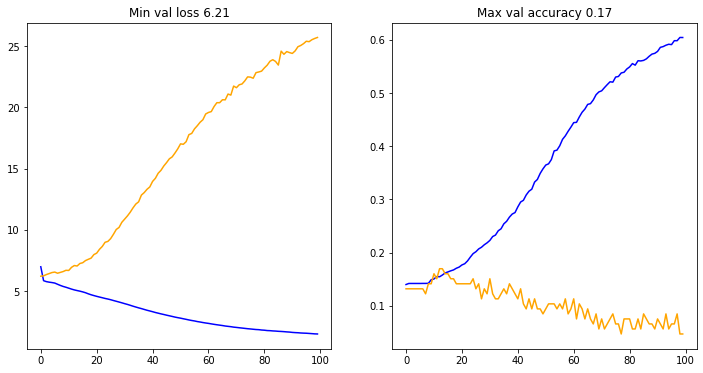

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test'); plt.title(f'Min val loss {min(history.history["val_loss"]):.2f}')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test'); plt.title(f'Max val accuracy {max(history.history["val_accuracy"]):.2f}')

# Text generation

In [ ]:
model = load_model('../models/model.h5',compile=False)
tokenizer = load(open('../models/tokenizer.pkl', 'rb'))

In [ ]:
#index_word = {v:k for k,v in tokenizer.word_index.items()}
def generate_seq(model, seq_length, seed_text, n_words,tokenizer=tokenizer):
    output = []
    text = seed_text
    for _ in range(n_words):
        #encoded = tokenizer.texts_to_sequences([text])[0] # encode the text as integer
        encoded = encode_seq([text], token_indices)[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre') #truncate sequences toa  fixed length (since reinputted)
        yhat = model.predict_classes(encoded, verbose=False)
        _word = indices_token[yhat[0]] # map predicted word index to word
        if _word == '$':
          return ' '.join(output)
        text += ' ' + _word
        output.append(_word)
        
seq_length = len(train[0].split()) - 1 # also defined as X.shape[1] above
seed_text = "it is my" #train[np.random.randint(0,len(train))]
print(seed_text + '\n')
generated = generate_seq(model, seq_length, seed_text, 20,tokenizer=None)
print(generated)

it is my



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


drug / My best friend / Long talks turned into silence / amidst the chaos


# Evaluation

Some weird oscillating output (even though I am going beyond haiku length wanted to see what it generates)

```
I called my

legs upon the leaves ns died with harsh broken coming ns i am stuck at work ns i am stuck at work ns i am stuck at work ns i am stuck at work ns i am stuck at work ns i am stuck at work ns i am stuck at work ns i am stuck at work ns i am stuck at work ns i am stuck at work ns i am stuck at work ns i am stuck at work ns i am stuck at work ns i am stuck at work ns i am stuck at work
```

- Need to figure out better tokens
- Hyperparams
    - see [this](https://stackoverflow.com/questions/56849552/lstm-getting-caught-up-in-loop)